In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [2]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)

    # There should be a method for this, but there isn't... Pull request?
    ax2._r_label_position._t = (22.5 + 180, 0.0)
    ax2._r_label_position.invalidate()
    return ax2

def plot_scale(r_max_psi, r_max_P):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, axs = plt.subplots(1,1,subplot_kw=dict(polar=True))

    axs.vlines(-np.pi/4, 0, r_max_psi, color='lightcoral', alpha=0.8, zorder=3, linewidth=4)

    axs.set_rmax(r_max_psi)
    axs.set_rticks([0,r_max_psi/2,r_max_psi], [r'0', str(round(r_max_psi/2,3)),str(round(r_max_psi,3))], color='lightcoral', fontsize=38)
    axs.set_rlabel_position(-45)

    #axs.set_xticklabels([0,np.pi/2,np.pi,3*np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2])
    axs.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
    axs.set_thetagrids([0,45,90,180,225,270],[r'$0$',r'',r'$\pi/2$',r'$\pi$',r'',r'$3\pi/2$'], fontsize=38, color='blue')

    axs.annotate(r'$|\varphi_{ij}|^2$', xy=(7*np.pi/4, r_max_psi), xytext=(0.96*7*np.pi/4, 1.25*r_max_psi), fontsize=45, color='lightcoral')


    axs_twin = polar_twin(axs)
    #axs[i, j].arrow(0, 0, theta, magnitude, zorder=3)
    axs_twin.vlines(3*np.pi/4, 0, r_max_P, color='black', alpha=0.8, zorder=3, linewidth=4)

    axs_twin.annotate(r'$|\vec{P}|$', xy=(3*np.pi/4, r_max_P), xytext=(1.1*3*np.pi/4, 1.5*r_max_P), fontsize=45)

    axs_twin.set_rmax(r_max_P)
    axs_twin.set_rticks([0,r_max_P/2,r_max_P], [r'0',str(r_max_P/2),str(r_max_P)], color='black', fontsize=38)
    axs_twin.set_rlabel_position(135)

    axs_twin.spines['polar'].set_color('blue')

In [3]:
def find_single_digit_rep(no):
    if no < 1.:
        no1 = np.round(np.log10(no))
        no2 = no/10**no1
        if no1 == -1:
            no3 = np.round(no2,1)*10**no1 
        else:
            no3 = np.round(no2)*10**no1 
    elif no >= 1.:
        no3 = np.ceil(no)
    return no3

def plot_rotor_wavefunction_and_polarization(title, x, chosen_My, chosen_Mx, psi, Px, Py, max_psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 
    
    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True), figsize=(5,5))
    plt.subplots_adjust(wspace=-0.01, hspace=0.15)
    
    plt.suptitle(title, fontsize=30)

    theta = np.arctan2(Py,Px)
    magnitude = np.sqrt(np.abs(Py)**2+np.abs(Px)**2)
    
    max_P = np.max(magnitude)
    max_psi = np.max(psi)

    r_max_psi = find_single_digit_rep(1.05*max_psi)
    r_max_P = find_single_digit_rep(1.05*max_P)

    print(r_max_psi, max_psi, r_max_P, max_P)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            iy = i #(i+int(chosen_My/2))%chosen_My
            ix = j #(j+int(chosen_Mx/2))%chosen_Mx
            
            '''  
            Polarization Vector
            '''
            axs_twin = polar_twin(axs[i,j])
            
            if magnitude[iy,ix] > 1e-4:
                axs_twin.annotate("", xy=(theta[iy,ix], magnitude[iy,ix]), xytext=(0.0, 0.0),arrowprops=dict(facecolor='black', arrowstyle="->"))
                #axs_twin.vlines(theta[iy,ix], 0, magnitude[iy,ix], color='black', alpha=0.8, zorder=3)
                #axs[i, j].arrow(0, 0, theta, magnitude, zorder=3)

            axs_twin.set_rmax(r_max_P)
            
            axs_twin.set_yticklabels([])
            axs_twin.set_xticklabels([])

            axs_twin.set_rticks([0,r_max_P/2,r_max_P])
            
            '''  
            Distribution
            '''
            axs[i, j].plot(x, psi[iy,ix], color='lightcoral', zorder=2)
            
            axs[i,j].set_rticks([0,r_max_psi/2,r_max_psi])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].set_rmax(r_max_psi)
            
            axs[i, j].grid(linewidth=0.5, zorder=1)
            axs[i, j].spines['polar'].set_linewidth(0.5) #.set_visible(False)

    axs[0,3].set_rticks([0,r_max_psi/2,r_max_psi], color='lightcoral')
    return r_max_psi, r_max_P

In [4]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [5]:
def solve_imag_time_prop(params):
    Mx = params["Mx"]
    My = params["My"]

    n = params["n"]
    V_0 = params["V_0"]

    wfn_manip = h_wavef.wavefunc_operations(params=params)
    wavefunc_object = h_wavef.wavefunctions(params=params)
    eom_object = eom.eom(params=params) 

    eom_object.V_0 = V_0
    wavefunc_object.V_0 = V_0 

    psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
    psi_init = wfn_manip.reshape_one_dim(psi_init)
        
    psi_0 = psi_init.copy() # for green function 

    # energy objects
    energy_object = energy.energy(params=params)
    overlap_object = energy.coupling_of_states(params=params) # needed for overlap calculations
        
    energy_object.V_0 = V_0
    overlap_object.V_0 = V_0

    # lambda expression of right-hand-side of e.o.m
    func = eom_object.create_integration_function_imag_time_prop() 

    iter = 0
    epsilon = 1 
    tol = params['tol']
    dt  = params['dt']
    E_converge_list = []
    while epsilon > tol:
        #print('V_0 =', V_0, ', iter step = ' + str(iter+1))
            
        '''
        imag time evolution for dt
        '''
        sol = solve_ivp(func, [0,dt], psi_init, method='RK45', rtol=1e-9, atol=1e-9) # method='RK45','DOP853'

        '''
        normalize
        '''
        psi_iter = sol.y.T[-1]
        psi_iter = wfn_manip.normalize_wf(psi_iter, shape=(int(Mx*My),n))

        '''
        compute and save energy and epsilon criterion
        '''
        E = energy_object.calc_energy(psi_iter)
        E_converge_list.append(E[0].real)
        epsilon = eom_object.epsilon_criterion_single_rotor(psi_iter, psi_init)
        #print("E =", E[0].real, ", epsilon =", epsilon, "\n")

        '''
        update psi_init
        '''
        psi_init = wfn_manip.reshape_one_dim(psi_iter)
        iter = iter + 1

    psi_out = wfn_manip.reshape_three_dim(psi_init)
    
    V_final = energy_object.calc_energy(psi_out)[3]
    dE_dtx, dE_dty = energy_object.deriv_dE_dt(psi_out)
    return psi_out, E_converge_list, V_final, dE_dtx, dE_dty

In [6]:
def get_polarization(x, psi, My, Mx):
    Px = np.zeros((My,Mx), dtype=complex)
    Py = np.zeros((My,Mx), dtype=complex)
    for i in range(My):
        for j in range(Mx):
            Px[i,j] = np.sum(psi[i,j]*np.cos(x))
            Py[i,j] = np.sum(psi[i,j]*np.sin(x))
    
    return Px, Py

In [7]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-7}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 

exc_number = params["excitation_no"]

In [8]:
params["tx"] = tx
params["ty"] = ty
params["V_0"] = 150

params["tol"] = 1e-6

params["init_choice"] = "uniform"
psi_fo, E_evo_fo, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "ferro_domain_vertical_wall"
psi_fdv, E_evo_fdv, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "ferro_domain_horizontal_wall"
psi_fdh, E_evo_fdh, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "small_polaron"
psi_sp, E_evo_sp, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

max_psi = np.max(np.array([np.abs(psi_fo)**2,np.abs(psi_fdv)**2,np.abs(psi_fdh)**2,np.abs(psi_sp)**2])).real

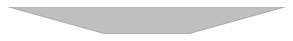

In [9]:
fig, axs = plt.subplots(figsize=(5,0.5))

xpoints = [0.35,0.65,1,0] #[0.3,0.6,.5,.4]
ypoints = [0,0,0.2,0.2]
axs.add_patch(patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color='grey', alpha=0.5))

plt.ylim(0,0.2)
axs.axis('off')

extent = axs.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('results/configurations/connection.svg', bbox_inches=extent, pad_inches=0)

0.03 0.024714857070542304 5.0 4.2157659955384235


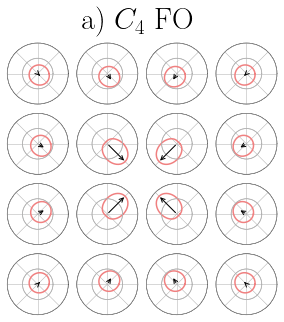

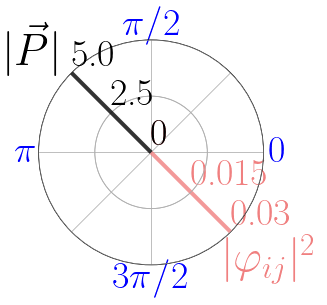

In [89]:
psi_analyse = psi_fo
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = 1 #(np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'a) $C_4$ FO', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fo.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fo_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fo.svg')
fig2 = sg.fromfile('results/configurations/fo_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(120, 350, 0.3) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

#fig.append([txt1,txt2,txt3,txt4])

fig.save('results/configurations/fo.svg')

0.06999999999999999 0.06726287805852016 9.0 7.638457171260688


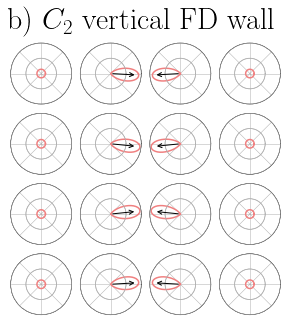

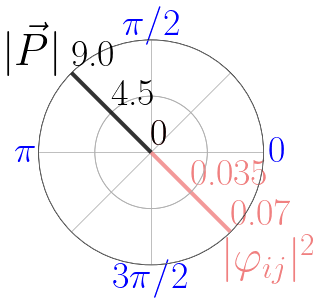

In [90]:
psi_analyse = psi_fdv
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = (np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'b) $C_2$ vertical FD wall', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fdv.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fdv_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fdv.svg')
fig2 = sg.fromfile('results/configurations/fdv_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(120, 350, 0.3) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/fdv.svg')

0.06999999999999999 0.0672628780536411 9.0 7.6384571712607405


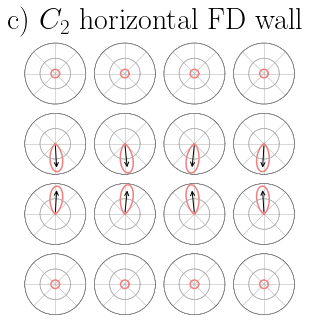

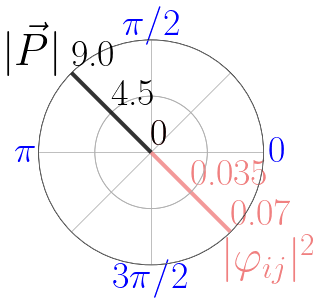

In [91]:
psi_analyse = psi_fdh
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = 1 #(np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'c) $C_2$ horizontal FD wall', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fdh.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fdh_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fdh.svg')
fig2 = sg.fromfile('results/configurations/fdh_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(120, 350, 0.3) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/fdh.svg')

0.11000000000000001 0.10158543976977238 7.0 6.63478663805645


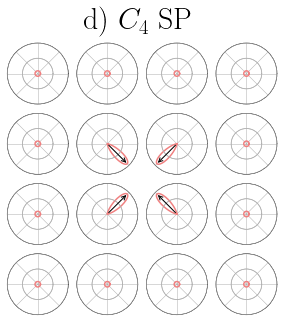

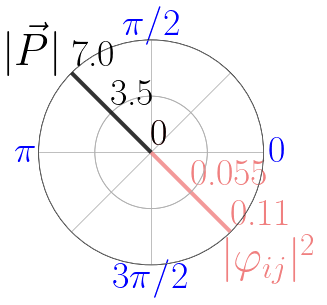

In [92]:
psi_analyse = psi_sp
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = (np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'd) $C_4$ SP', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/sp.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/sp_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/sp.svg')
fig2 = sg.fromfile('results/configurations/sp_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(120, 350, 0.3) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/sp.svg')

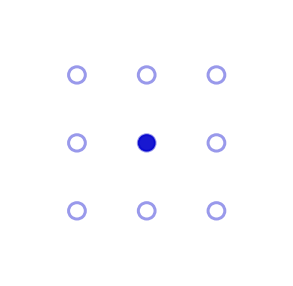

In [93]:
fig = plt.figure(figsize=(5,5))

for i in range(1,4):
    for j in range(1,4):
        circle = plt.Circle((i*0.25,j*0.25), 0.03, color='mediumblue', alpha=0.4, linewidth=3, fill=False)
        plt.gca().add_patch(circle)

circle = plt.Circle((0.5,0.5), 0.03, alpha=0.9, color='mediumblue')
plt.gca().add_patch(circle)

plt.axis('off')
plt.savefig('results/configurations/circle.svg', transparent=True)

In [94]:
import svgutils.transform as sg 

fig = sg.SVGFigure("75cm", "20cm")

fig1 = sg.fromfile('results/configurations/fo.svg')
fig2 = sg.fromfile('results/configurations/fdv.svg')
fig3 = sg.fromfile('results/configurations/fdh.svg')
fig4 = sg.fromfile('results/configurations/sp.svg')

figc1 = sg.fromfile('results/configurations/circle.svg')
figc2 = sg.fromfile('results/configurations/circle.svg')
figc3 = sg.fromfile('results/configurations/circle.svg')
figc4 = sg.fromfile('results/configurations/circle.svg')


plot1 = fig1.getroot()
plot1_1 = figc1.getroot()
plot2 = fig2.getroot()
plot2_1 = figc2.getroot()
plot3 = fig3.getroot()
plot3_1 = figc3.getroot()
plot4 = fig4.getroot()
plot4_1 = figc4.getroot()

plot2.moveto(350, 0)
plot2_1.moveto(350, 0)
plot3.moveto(700, 0)
plot3_1.moveto(700,0)
plot4.moveto(1050, 0)
plot4_1.moveto(1050, 0)

txt1 = sg.TextElement(5,40, "A)", size=30, weight="bold")
txt2 = sg.TextElement(355,40, "B)", size=30, weight="bold")
txt3 = sg.TextElement(705,40, "C)", size=30, weight="bold")
txt4 = sg.TextElement(1055,40, "D)", size=30, weight="bold")

fig.append([plot1,plot1_1,plot2,plot2_1,plot3,plot3_1,plot4,plot4_1])
#fig.append([txt1,txt2,txt3,txt4])

fig.save('results/configurations/configurations.svg')
fig.save('results/configurations/configurations.pdf')

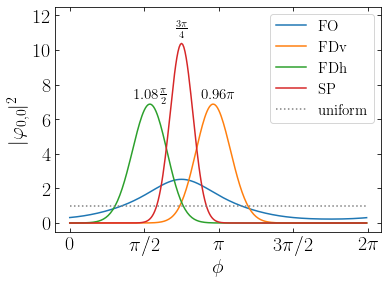

In [87]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

measure = n

plt.plot(x, np.abs(psi_fo[0,0])**2*measure, label=r'FO')
plt.plot(x, np.abs(psi_fdv[0,0])**2*measure, label=r'FDv')
plt.plot(x, np.abs(psi_fdh[0,0])**2*measure, label=r'FDh')
plt.plot(x, np.abs(psi_sp[0,0])**2*measure, label=r'SP')

plt.plot(x, np.abs(psi_sp[0,1])**2*measure, color='grey', linestyle='dotted', label=r'uniform')

fdv_max = x[np.argmax(np.abs(psi_fdv[0,0])**2)]
fdh_max = x[np.argmax(np.abs(psi_fdh[0,0])**2)]
sp_max = x[np.argmax(np.abs(psi_sp[0,0])**2)]

#plt.vlines(fdv_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:orange', linestyle='dashed', linewidth=1.2)
#plt.vlines(fdh_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:green', linestyle='dashed', linewidth=1.2)
#plt.vlines(sp_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:red', linestyle='dashed', linewidth=1.2)

plt.annotate(str(round(fdv_max/np.pi,2))+r'$\pi$', xy=(0.92*fdv_max,7.2), fontsize=15)
plt.annotate(str(round(fdh_max/(np.pi/2),2))+r'$\frac{\pi}{2}$', xy=(0.8*fdh_max,7.2), fontsize=15)
plt.annotate(r'$\frac{3\pi}{4}$', xy=(0.95*sp_max,11), fontsize=15)

plt.xlabel(r'$\phi$', fontsize=font_size)
plt.ylabel(r'$|\varphi_{0,0}|^2$', fontsize=font_size)

plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi], [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'], fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.ylim(-0.5,12.5)
#axs.set_yscale('log')

plt.legend(fontsize=15)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/configurations/wavefunction_comparison.svg')